# **<font color="#34ebdb">0.0 IMPORTS</font>**

In [2]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import warnings

# Model
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize, OneHotEncoder

# Neural Networks
import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from sklearn.neural_network import MLPClassifier, MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.regularizers import L1, L2
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor
# from keras_tuner import RandomSearch, HyperParameters
from sklearn.exceptions import ConvergenceWarning

# Regression
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
# Support Vector Machines
from sklearn.svm import LinearSVC, SVC, SVR
# Neighbors
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# Tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
# Bayes
from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB
# Ensemble
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingClassifier, GradientBoostingRegressor

# Evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, r2_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, log_loss
from sklearn.metrics.pairwise import paired_distances, euclidean_distances
from sklearn.metrics import make_scorer

# **<font color="#34ebdb">0.1 FUNCTIONS</font>**

In [4]:
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":16,"axes.labelsize":14})
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})

In [5]:
# Function to build keras model for CUP regression
def build_fn_cup(n_hidden_units1, n_hidden_units2, n_hidden_units3, learning_rate, lambd, ): 
    keras.backend.clear_session()
    tf.random.set_seed(42)

    model = Sequential()
    model.add(Dense(n_hidden_units1, input_dim = X_train.shape[1], kernel_regularizer = L2(lambd), kernel_initializer = 'glorot_normal', activation = 'relu'))
    model.add(Dense(n_hidden_units2, activation = 'relu'))
    model.add(Dense(n_hidden_units3, activation = 'relu'))
    model.add(Dense(y_train.shape[1], activation = 'linear'))
    model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate = learning_rate))

    return model

In [6]:
# Making MEE scorer for gridsearch
# def mean_euclidean_error(y_true, y_pred):
#     return np.mean(euclidean_distances(y_true, y_pred))

def mean_euclidean_error(y_true, y_pred):
    return np.mean(np.sqrt(np.sum(np.square(y_pred-y_true), axis=-1)))

mee_scoring = make_scorer(mean_euclidean_error, greater_is_better = False)

# Keras custom loss function
def mean_euclidean_error_keras(y_true, y_pred):
    return K.mean(K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1)))

In [7]:
# Function to get results from regression
def regression_results(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    return r2, mse, mae

In [8]:
# Function to fit mlp classifier with partial fit to get scores and loss 
def mlp_fit(mlp, max_iter):
    train_loss = []
    test_loss = []

    for i in range(max_iter):
        mlp.partial_fit(X_train, y_train)
        y_pred = mlp.predict(X_train)
        y_pred_test = mlp.predict(X_test)

        train_loss.append(mean_euclidean_error(y_train, y_pred))
        test_loss.append(mean_euclidean_error(y_test, y_pred_test))

    print('Training loss:   ', round(train_loss[-1],4))
    print('Testing loss:    ', round(test_loss[-1],4), '\n')

    return train_loss, test_loss

In [9]:
# Function to create score and loss plots
def plot_score_loss(train_loss, test_loss, save, name):
    plt.figure(figsize = (6, 4))
    plt.plot(train_loss, label='Train')
    plt.plot(test_loss, label='test', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    if save == 1:
        plt.savefig(name+'_loss', dpi=400)
    plt.show()

In [10]:
# Function to apply nested cross validation on a series of models and parameters
def nested_cross_validation(folds, model_to_use, model_params, param_grid):
    outer_kfold = KFold(folds, shuffle=True, random_state=42)
    inner_kfold = KFold(folds, shuffle=True, random_state=77) 

    test_scores = []

    X = X_train
    y = y_train

    # Outer K-Fold (Evaluation)
    for train_indices, test_indices in outer_kfold.split(X, y):
        # Split data into train and test
        X_train_nested, y_train_nested = X[train_indices], y[train_indices]
        X_test_nested, y_test_nested = X[test_indices], y[test_indices]
        
        models = {}

        # Initializing param_grid
        list_params = ['param'+str(i) for i in range(len(model_params))]
        for list_params[0] in param_grid[0]:
            for list_params[1] in param_grid[1]:
                for list_params[2] in param_grid[2]:

                    val_scores = []

                    # Inner K-Fold for each hyper-parameter configuration
                    for selection_indices, val_indices in inner_kfold.split(X_train_nested, y_train_nested):

                        # Split data into selection and validation
                        X_selection, y_selection = X_train_nested[selection_indices], y_train_nested[selection_indices]
                        X_val, y_val = X_train_nested[val_indices], y_train_nested[val_indices]

                        # Fit the model
                        params = {model_params[i]: list_params[i] for i in range(len(model_params))}

                        if name == "Support Vector Machine":
                            model = model_to_use(SVR(**params))
                        else:
                            model = model_to_use(**params)

                        model.fit(X_selection, y_selection)
                        y_pred_val = model.predict(X_val) 
                        val_scores.append(mean_euclidean_error(y_val, y_pred_val))
                    
                    # Validation score of a model is the mean over the inner k-folds
                    models[(list_params[0], list_params[1], list_params[2])] = np.mean(val_scores)

        best_params = max(models, key=models.get)
        
        best_params_dict = {model_params[i]: best_params[i] for i in range(len(model_params))}

        if name == "Support Vector Machine":
            model = model_to_use(SVR(**best_params_dict))
        else:
            model = model_to_use(**best_params_dict)
            
        model.fit(X_train_nested, y_train_nested)
        y_pred_test = model.predict(X_test_nested) 
        test_scores.append(mean_euclidean_error(y_test_nested, y_pred_test))

    avg_mee = round(np.mean(test_scores), 4)
    std_mee = round(np.std(test_scores), 4)

    return avg_mee, std_mee

# **<font color="#34ebdb">1.0 DATA UNDERSTANDING & PREPARATION</font>**

In [11]:
# Monto il Drive per accedere ai file, basta avere una scorciatoia alla cartella "CUP" nella cartella principale del vostro drive
from google.colab import drive
drive.mount('/content/drive') 

# Creating local files to access more easily
!mkdir dataset

!cp -r /content/drive/MyDrive/CUP /content/dataset

Mounted at /content/drive


In [12]:
# Reading csv file to create pandas dataframe, assigning target_x and target_y column names
TR_CUP = pd.read_csv('/content/dataset/CUP/ML-CUP22-TR.csv', header=None, comment='#') 
TR_CUP.drop(labels=0, axis=1, inplace=True)
TR_CUP.rename({10: 'target_x', 11: 'target_y'}, axis=1, inplace=True)

# Overview of the structure and info of dataframe
print(TR_CUP.info())
TR_CUP.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   1         1492 non-null   float64
 1   2         1492 non-null   float64
 2   3         1492 non-null   float64
 3   4         1492 non-null   float64
 4   5         1492 non-null   float64
 5   6         1492 non-null   float64
 6   7         1492 non-null   float64
 7   8         1492 non-null   float64
 8   9         1492 non-null   float64
 9   target_x  1492 non-null   float64
 10  target_y  1492 non-null   float64
dtypes: float64(11)
memory usage: 128.3 KB
None


,1,2,3,4,5,6,7,8,9,target_x,target_y
0,-1.704815,1.503106,-0.817083,1.353560,-1.293660,1.362608,0.217795,0.462728,-1.237246,22.222923,-27.036774
1,-0.888962,0.711473,-0.480023,0.748175,-0.981763,1.765482,-0.445018,1.719143,-1.096250,18.885520,-28.377440
2,1.143802,-1.591273,0.670477,-0.948551,1.075740,-0.908309,-0.694223,-1.321391,0.662656,4.587627,-18.507566
3,0.630938,-0.295533,1.379162,-0.041045,-0.250695,0.025003,0.143915,0.861455,0.879540,10.256820,-30.017064
4,1.799449,-0.913254,1.245698,-1.410940,0.653328,-0.677108,-0.667490,-0.849795,0.497977,4.916182,-17.670030


In [13]:
# Repeating the previous steps, this time for test set
TS_CUP = pd.read_csv('/content/dataset/CUP/ML-CUP22-TS.csv', header=None, comment='#') 
TS_CUP.drop(labels=0, axis=1, inplace=True)
print(TS_CUP.info())
TS_CUP.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       529 non-null    float64
 1   2       529 non-null    float64
 2   3       529 non-null    float64
 3   4       529 non-null    float64
 4   5       529 non-null    float64
 5   6       529 non-null    float64
 6   7       529 non-null    float64
 7   8       529 non-null    float64
 8   9       529 non-null    float64
dtypes: float64(9)
memory usage: 37.3 KB
None


,1,2,3,4,5,6,7,8,9
0,-1.295403,1.471468,-0.394740,0.982752,-1.287838,1.427106,-0.052994,0.890491,-1.258837
1,0.351257,-0.583818,1.673024,-1.045503,0.566956,-0.603433,0.417183,-0.516325,0.902252
2,0.076491,0.551166,0.157875,0.545169,-0.189986,0.876511,2.167689,0.621724,0.259727
3,-1.362116,1.111719,-0.593551,0.713629,-1.174274,1.767917,0.152496,1.152507,-0.851621
4,1.261212,-0.816557,-0.218964,-0.875395,0.518453,-0.854788,0.150214,-0.858207,1.426335


In [14]:
# X takes values of attributes 1 to 9, while y takes the targets x and y
X_CUP_train = TR_CUP.values[:,0:9].astype(np.float32)
y_CUP_train = TR_CUP.values[:,9:11].astype(np.float32)

X_CUP_test = TS_CUP.values.astype(np.float32)

# Looking at the shape of the values
print(X_CUP_train.shape, y_CUP_train.shape)
print(X_CUP_test.shape)

(1492, 9) (1492, 2)
(529, 9)


In [15]:
# Validation schema
X_train, X_test, y_train, y_test = train_test_split(X_CUP_train, y_CUP_train, test_size = .1, random_state = 42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size = .2, random_state = 0)
X_test_blind = X_CUP_test

min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
# X_val = min_max_scaler.fit_transform(X_val)
X_test = min_max_scaler.fit_transform(X_test)

print('Dataset:', X_CUP_train.shape[0])
print('TR:     ', X_train.shape[0])
# print('Validation set:   ', X_val.shape[0])
print('TS:     ', X_test.shape[0])
print('Blind:  ', X_test_blind.shape[0])

Dataset: 1492
TR:      1342
TS:      150
Blind:   529


In [16]:
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
regression_results(y_test, y_pred)

(0.8270168096123083, 4.000409, 1.5895364)

In [17]:
# blind_test_results = pd.DataFrame({'Pred x_target': y_pred[:,0], 'Pred y_target': y_pred[:,1]})
test_results = pd.DataFrame({'True x_target': y_test[:,0], 'Pred x_target': y_pred[:,0], 'True y_target': y_test[:,1], 'Pred y_target': y_pred[:,1]})
test_results

,True x_target,Pred x_target,True y_target,Pred y_target
0,8.240253,6.673492,-28.361589,-25.772501
1,21.146860,20.210459,-29.024191,-29.414347
2,17.441263,20.063807,-29.298223,-26.983648
3,16.170891,16.064413,-29.233570,-31.620787
4,4.336274,4.393714,-22.644592,-24.024273
...,...,...,...,...
145,4.800615,5.992147,-19.232483,-20.155365
146,12.941359,13.414674,-30.530289,-27.394241
147,4.408616,3.357135,-22.928535,-25.194374
148,17.921104,20.961601,-28.490801,-29.061752


# **<font color="#34ebdb">2.0 NEURAL NETWORKS</font>**

### **<font color="#CEFF5E">KERAS</font>**

In [ ]:
model = KerasRegressor(build_fn_cup, n_hidden_units1 = 0, n_hidden_units2 = 0, n_hidden_units3 = 0, learning_rate = 0, lambd = 0, epochs = 150, verbose = 0)

param_grid = {'n_hidden_units1': range(10, 100, 20),
              'n_hidden_units2': range(0, 100, 20),
              'n_hidden_units3': range(0, 100, 20),
              'learning_rate': [.01],
              'lambd': [0],
              'batch_size': [512, 2048],
              }

search = GridSearchCV(estimator = model, 
                      param_grid = param_grid, 
                      cv = KFold(5, shuffle = True, random_state = 42),
                      scoring = mee_scoring,
                      verbose = 1).fit(X_train, y_train, verbose = 0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best score: -1.8237561464309693 
Best params {'batch_size': 512, 'lambd': 0, 'learning_rate': 0.01, 'n_hidden_units1': 30, 'n_hidden_units2': 80, 'n_hidden_units3': 80}


In [ ]:
model = KerasRegressor(build_fn_cup, n_hidden_units1 = 30, n_hidden_units2 = 80, n_hidden_units3 = 80, learning_rate = 0, lambd = 0, epochs = 150, verbose = 0)

param_grid = {'learning_rate': [.001, .01, .1, 1],
              'lambd': [.001, .01, .1],
              'batch_size': [512],
              }

search = GridSearchCV(estimator = model, 
                      param_grid = param_grid, 
                      cv = KFold(5, shuffle = True, random_state = 42),
                      scoring = mee_scoring,
                      verbose = 1).fit(X_train, y_train, verbose = 0)

print('Best score:', search.best_score_, '\nBest params', search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: -1.8114975452423097 
Best params {'batch_size': 512, 'lambd': 0.01, 'learning_rate': 0.01}


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                300       
                                                                 
 dense_1 (Dense)             (None, 80)                2480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 2)                 162       
                                                                 
Total params: 9,422
Trainable params: 9,422
Non-trainable params: 0
_________________________________________________________________
Training MEE:  2.0372698307037354
Validation MEE 1.91669499874115


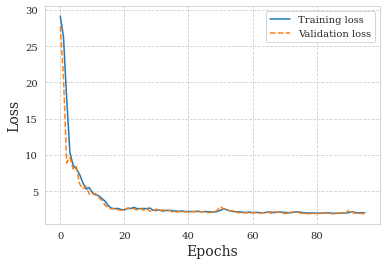

In [271]:
keras.backend.clear_session()
tf.random.set_seed(42)

es = EarlyStopping(monitor = 'val_loss',
                   mode = 'min',
                   patience = 10,
                   restore_best_weights = True)

model = Sequential()
model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = 'glorot_normal', activation = 'relu', kernel_regularizer=L2(.01)))
model.add(Dense(80, activation = 'relu'))
model.add(Dense(80, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation = 'linear'))
model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=.01))
model.summary()

history = model.fit(X_train, y_train,
                    validation_split = .2,
                    callbacks = [es],
                    epochs = 200,
                    batch_size = 512,
                    verbose = 0)

loss = model.evaluate(X_train, y_train, verbose = 0)
print('Training MEE: ', history.history['loss'][-1])
print('Validation MEE', history.history['val_loss'][-1])

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss', linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('CUP_Keras.png', dpi=400)
plt.show()

In [ ]:
iterations = 50
mee_train = []
mee_val = []
mee_test = []

list_act = ['relu', 'sigmoid', 'tanh']
list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)  

for activation in list_act:
    print('------', activation,'------\n')
    for i in list_seeds:
        keras.backend.clear_session()
        tf.random.set_seed(i)

        es = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          patience = 10,
                          restore_best_weights = True)

        model = Sequential()
        model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = 'glorot_normal', activation = activation, kernel_regularizer=L2(.01)))
        model.add(Dense(80, activation = activation))
        model.add(Dense(80, activation = activation))
        model.add(Dense(y_train.shape[1], activation = 'linear'))
        model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=.01))

        history = model.fit(X_train, y_train,
                            validation_split = .2,
                            callbacks = [es],
                            epochs = 200,
                            batch_size = 512,
                            verbose = 0)
        
        mee_train.append(history.history['loss'][-1])
        mee_val.append(history.history['val_loss'][-1])

    print('Avg mee train:', round(np.mean(mee_train),4))
    print('Std dev:      ', round(np.std(mee_train),4))
    print('Avg mee val:  ', round(np.mean(mee_val),4))
    print('Std dev:      ', round(np.std(mee_val),4),'\n')

------ relu ------

Avg mee train: 1.8166
Std dev:       0.1355
Avg mee val:   1.8163
Std dev:       0.1876
------ sigmoid ------

Avg mee train: 4.472
Std dev:       2.6571
Avg mee val:   4.4526
Std dev:       2.6397
------ tanh ------

Avg mee train: 4.2324
Std dev:       2.7124
Avg mee val:   4.2092
Std dev:       2.7016


In [ ]:
iterations = 50
mee_train = []
mee_val = []
mee_test = []

list_init = ['glorot_normal', 'random_normal', 'he_normal']
list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)  

for initializer in list_init:
    print('------', initializer,'------\n')
    for i in list_seeds:
        keras.backend.clear_session()
        tf.random.set_seed(i)

        es = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          patience = 10,
                          restore_best_weights = True)

        model = Sequential()
        model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = initializer, activation = 'relu', kernel_regularizer=L2(.01)))
        model.add(Dense(80, activation = 'relu'))
        model.add(Dense(80, activation = 'relu'))
        model.add(Dense(y_train.shape[1], activation = 'linear'))
        model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=.01))

        history = model.fit(X_train, y_train,
                            validation_split = .2,
                            callbacks = [es],
                            epochs = 200,
                            batch_size = 512,
                            verbose = 0)
        
        mee_train.append(history.history['loss'][-1])
        mee_val.append(history.history['val_loss'][-1])

    print('Avg mee train:', round(np.mean(mee_train),4))
    print('Std dev:      ', round(np.std(mee_train),4))
    print('Avg mee val:  ', round(np.mean(mee_val),4))
    print('Std dev:      ', round(np.std(mee_val),4),'\n')

------ glorot_normal ------

Avg mee train: 1.8454
Std dev:       0.186
Avg mee val:   1.8779
Std dev:       0.2275 

------ random_normal ------

Avg mee train: 1.9273
Std dev:       0.1856
Avg mee val:   1.9297
Std dev:       0.2095 

------ he_normal ------

Avg mee train: 1.8938
Std dev:       0.1807
Avg mee val:   1.9028
Std dev:       0.211 



In [ ]:
iterations = 50
mee_train = []
mee_val = []
mee_test = []

list_eta = [.001, .01, .1, 1]
list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)  

for eta in list_eta:
    print('------', eta,'------\n')
    for i in list_seeds:
        keras.backend.clear_session()
        tf.random.set_seed(i)

        es = EarlyStopping(monitor = 'val_loss',
                          mode = 'min',
                          patience = 10,
                          restore_best_weights = True)

        model = Sequential()
        model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = 'glorot_normal', activation = 'relu', kernel_regularizer=L2(.01)))
        model.add(Dense(80, activation = 'relu'))
        model.add(Dense(80, activation = 'relu'))
        model.add(Dense(y_train.shape[1], activation = 'linear'))
        model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=eta))

        history = model.fit(X_train, y_train,
                            validation_split = .2,
                            callbacks = [es],
                            epochs = 200,
                            batch_size = 512,
                            verbose = 0)
        
        mee_train.append(history.history['loss'][-1])
        mee_val.append(history.history['val_loss'][-1])

    print('Avg mee train:', round(np.mean(mee_train),4))
    print('Std dev:      ', round(np.std(mee_train),4))
    print('Avg mee val:  ', round(np.mean(mee_val),4))
    print('Std dev:      ', round(np.std(mee_val),4),'\n')

------ 0.001 ------

Avg mee train: 1.8451
Std dev:       0.113
Avg mee val:   1.8142
Std dev:       0.1326 

------ 0.01 ------

Avg mee train: 1.8452
Std dev:       0.1539
Avg mee val:   1.846
Std dev:       0.1889 

------ 0.1 ------

Avg mee train: 2.0097
Std dev:       0.5193
Avg mee val:   2.0177
Std dev:       0.5554 

------ 1 ------

Avg mee train: 8.815
Std dev:       14.44
Avg mee val:   8.7384
Std dev:       14.255 



In [ ]:
iterations = 50

train_loss = []
train_r2 = []
train_mse = []
train_mae = []

test_loss = []
test_r2 = []
test_mse = []
test_mae = []

list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)  

for i in list_seeds:
  keras.backend.clear_session()
  tf.random.set_seed(i)

  es = EarlyStopping(monitor = 'val_loss',
                    mode = 'min',
                    patience = 10,
                    restore_best_weights = True)

  model = Sequential()
  model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = 'glorot_normal', activation = 'relu', kernel_regularizer=L2(.01)))
  model.add(Dense(80, activation = 'relu'))
  model.add(Dense(80, activation = 'relu'))
  model.add(Dense(y_train.shape[1], activation = 'linear'))
  model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=.001))

  history = model.fit(X_train, y_train,
                         validation_split = .2,
                         callbacks = [es],
                         epochs = 200,
                         batch_size = 512,
                         verbose = 0)
     
  # train_loss.append(history.history['loss'][-1])
  y_pred = model.predict(X_train, verbose = 0)
  y_pred_test = model.predict(X_test, verbose = 0)

  tr_r2, tr_mse, tr_mae = regression_results(y_train, y_pred)
  ts_r2, ts_mse, ts_mae = regression_results(y_test, y_pred_test)

  train_loss.append(mean_euclidean_error(y_train, y_pred))
  train_r2.append(tr_r2)
  train_mse.append(tr_mse)
  train_mae.append(tr_mae)

  test_loss.append(mean_euclidean_error(y_test, y_pred_test))
  test_r2.append(ts_r2)
  test_mse.append(ts_mse)
  test_mae.append(ts_mae)

print('Train loss:  ', round(np.mean(train_loss),4))
print('Std dev:     ', round(np.std(train_loss),4))
print('Train r2:    ', round(np.mean(train_r2),4))
print('Std dev:     ', round(np.std(train_r2),4))
print('Train mse:   ', round(np.mean(train_mse),4))
print('Std dev:     ', round(np.std(train_mse),4))
print('Train mae:   ', round(np.mean(train_mae),4))
print('Std dev:     ', round(np.std(train_mae),4))

print('Testing loss:', round(np.mean(test_loss),4))
print('Std dev:     ', round(np.std(test_loss),4))
print('Testing r2:  ', round(np.mean(test_r2),4))
print('Std dev:     ', round(np.std(test_r2),4))
print('Testing mse: ', round(np.mean(test_mse),4))
print('Std dev:     ', round(np.std(test_mse),4))
print('Testing mae: ', round(np.mean(test_mae),4))
print('Std dev:     ', round(np.std(test_mae),4))

Train loss:   1.9754
Std dev:      0.0593
Train r2:     0.8803
Std dev:      0.0069
Train mse:    2.6746
Std dev:      0.1485
Train mae:    1.2355
Std dev:      0.0387
Testing loss: 2.3047
Std dev:      0.066
Testing r2:   0.8362
Std dev:      0.0084
Testing mse:  3.5694
Std dev:      0.1895
Testing mae:  1.4382
Std dev:      0.0439


In [ ]:
list_seeds

array([42, 36, 24, 25, 17, 41, 38, 19, 26, 40, 48, 16, 29, 18,  4, 31, 10,
       44, 47, 23, 35, 45, 12,  1, 43, 30,  0,  3,  8,  6, 28, 13,  5, 14,
       20, 33, 34, 15, 37, 21, 27, 46,  7, 22,  2,  9, 49, 39, 11, 32])

TR: 2.0392
VL: 1.9529
TS: 2.265


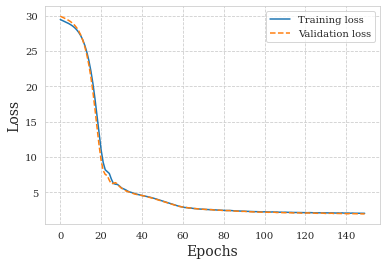

In [274]:
keras.backend.clear_session()
tf.random.set_seed(45)

es = EarlyStopping(monitor = 'val_loss',
                  mode = 'min',
                  patience = 5,
                  restore_best_weights = True)

model = Sequential()
model.add(Dense(30, input_dim = X_train.shape[1], kernel_initializer = 'glorot_normal', activation = 'relu', kernel_regularizer=L2(.01)))
model.add(Dense(80, activation = 'relu'))
model.add(Dense(80, activation = 'relu'))
model.add(Dense(y_train.shape[1], activation = 'linear'))
model.compile(loss = mean_euclidean_error_keras, optimizer = Adam(learning_rate=.001))

history = model.fit(X_train, y_train,
                    validation_split = .2,
                    callbacks = [es],
                    epochs = 150,
                    batch_size = 512,
                    verbose = 0)

y_pred = model.predict(X_test, verbose = 0)
print('TR:', round(history.history['loss'][-1],4))
print('VL:', round(history.history['val_loss'][-1],4))
print('TS:', round(mean_euclidean_error(y_test, y_pred),4))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss', linestyle="--")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('CUP_Keras.png', dpi=400)
plt.show()

### **<font color="#CEFF5E">SCIKITLEARN'S MLP</font>**

In [ ]:
# different learning rate schedules and momentum parameters
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "momentum": 0,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
    },
    {
        "solver": "adam", 
        "learning_rate_init": 0.02
    },
]

labels = [
    "constant learning w/o momentum",
    "constant with momentum",
    "constant with Nesterov's momentum",
    "adaptive learning w/o momentum",
    "adaptive with momentum",
    "adaptive with Nesterov's momentum",
    "adam",
]

In [ ]:
models = []
for label, param in zip(labels, params):
    print("training", label)
    mlp = MLPRegressor(random_state=42, max_iter=100, **param)

    # some parameter combinations will not converge so they are ignored here
    with warnings.catch_warnings():
      warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
      mlp.fit(X_train, y_train)

    models.append(mlp)
    # print("Score: %f" % mlp.score(X3_val, y3_val))
    print("Loss: %f" % mlp.loss_,'\n')

training constant learning w/o momentum
Loss: 15.036825 

training constant with momentum
Loss: 15.293155 

training constant with Nesterov's momentum
Loss: 28.475362 

training adaptive learning w/o momentum
Loss: 15.031584 

training adaptive with momentum
Loss: 15.248222 

training adaptive with Nesterov's momentum
Loss: 28.453780 

training adam
Loss: 1.345589 



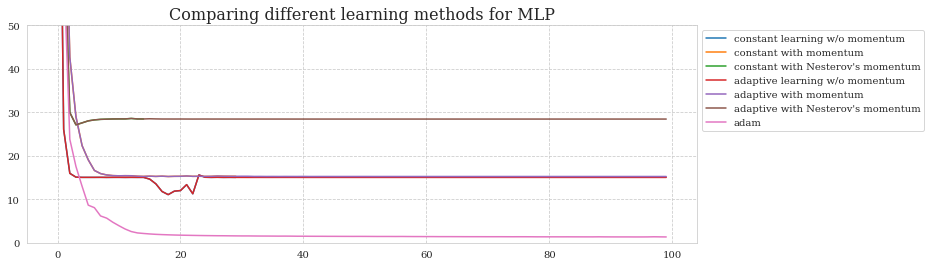

In [ ]:
plt.figure(figsize=(12,4))
for i, label in zip(range(len(models)), labels):
  plt.plot(models[i].loss_curve_, label = label)
plt.title("Comparing different learning methods for MLP")
plt.ylim(0,50)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
plt.show()

In [ ]:
max_iter = 150
model = MLPRegressor(solver='adam', max_iter=max_iter, random_state=42)

param_grid = {'hidden_layer_sizes': [(10, 10, 10), (30, 30, 30), (50, 50, 50),(70, 70, 70), (100, 100, 100)],
              'momentum': [.01, .1, 1], 
              'learning_rate_init': [.01, .1, 1],
              'batch_size': [512, 'auto']}

with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
  search = GridSearchCV(estimator = model, 
                        param_grid = param_grid, 
                        cv = KFold(5, shuffle = True, random_state = 42), 
                        scoring = mee_scoring,
                        verbose = 1).fit(X_train, y_train)
        
print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best score: -1.741400170326233 
Best params MLPRegressor(hidden_layer_sizes=(100, 100, 100), learning_rate_init=0.01,
             max_iter=150, momentum=0.01, random_state=42)


In [ ]:
max_iter = 150
model = MLPRegressor(solver='adam', max_iter=max_iter, random_state=42)

param_grid = {'hidden_layer_sizes': [(100, 100, 100), (125, 125, 125), (150, 150, 150)],
              'momentum': [.08, .01, .03], 
              'learning_rate_init': [.08, .01, .03],
              'batch_size': ['auto']}

with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
  search = GridSearchCV(estimator = model, 
                        param_grid = param_grid, 
                        cv = KFold(5, shuffle = True, random_state = 42), 
                        scoring = mee_scoring,
                        verbose = 1).fit(X_train, y_train)
        
print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best score: -1.7102821111679076 
Best params MLPRegressor(hidden_layer_sizes=(125, 125, 125), learning_rate_init=0.01,
             max_iter=150, momentum=0.08, random_state=42)


In [ ]:
iterations = 50

train_loss = []
train_r2 = []
train_mse = []
train_mae = []

test_loss = []
test_r2 = []
test_mse = []
test_mae = []

list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)      

for i in list_seeds:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        mlp = MLPRegressor(batch_size = 'auto', 
                           hidden_layer_sizes = (125, 125, 125),
                           learning_rate_init = .01, 
                           max_iter = 150, 
                           momentum = .08,
                           random_state = i)

        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_train)
        y_pred_test = mlp.predict(X_test)

        tr_r2, tr_mse, tr_mae = regression_results(y_train, y_pred)
        ts_r2, ts_mse, ts_mae = regression_results(y_test, y_pred_test)

        train_loss.append(mean_euclidean_error(y_train, y_pred))
        train_r2.append(tr_r2)
        train_mse.append(tr_mse)
        train_mae.append(tr_mae)

        test_loss.append(mean_euclidean_error(y_test, y_pred_test))
        test_r2.append(ts_r2)
        test_mse.append(ts_mse)
        test_mae.append(ts_mae)


print('Train loss:', round(np.mean(train_loss),4))
print('Std dev:   ', round(np.std(train_loss),4))
print('Train r2:  ', round(np.mean(train_r2),4))
print('Std dev:   ', round(np.std(train_r2),4))
print('Train mse: ', round(np.mean(train_mse),4))
print('Std dev:   ', round(np.std(train_mse),4))
print('Train mae: ', round(np.mean(train_mae),4))
print('Std dev:   ', round(np.std(train_mae),4))

print('Testing loss:', round(np.mean(test_loss),4))
print('Std dev:     ', round(np.std(test_loss),4))
print('Testing r2:  ', round(np.mean(test_r2),4))
print('Std dev:     ', round(np.std(test_r2),4))
print('Testing mse: ', round(np.mean(test_mse),4))
print('Std dev:     ', round(np.std(test_mse),4))
print('Testing mae: ', round(np.mean(test_mae),4))
print('Std dev:     ', round(np.std(test_mae),4))

Train loss: 1.6463
Std dev:    0.1318
Train r2:   0.9092
Std dev:    0.0102
Train mse:  1.9866
Std dev:    0.2319
Train mae:  1.0239
Std dev:    0.0864
Testing loss: 1.8438
Std dev:      0.1262
Testing r2:   0.8795
Std dev:      0.0125
Testing mse:  2.5016
Std dev:      0.2684
Testing mae:  1.14
Std dev:      0.0842


In [ ]:
list_seeds

array([12, 27, 10,  5,  0, 34,  2, 44, 45, 25, 18, 11, 32,  4, 30, 17,  3,
       39, 19,  9, 47, 33, 38, 22, 41, 24, 36, 28, 16, 29,  1, 40, 21, 13,
       26,  8, 14,  7, 43, 37, 23, 20, 49, 35, 46, 31, 15, 42,  6, 48])

Training loss:    1.6668
Testing loss:     1.9539 



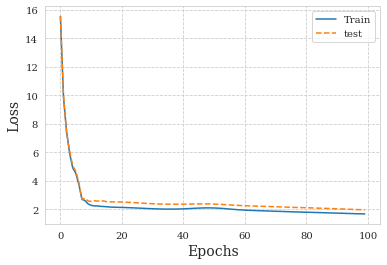

In [275]:
mlp = MLPRegressor(batch_size = 'auto', 
                   hidden_layer_sizes = (125, 125, 125),
                   learning_rate_init = .01, 
                   max_iter = 100, 
                   momentum = .08,
                   random_state = 32)

train_loss, test_loss = mlp_fit(mlp, max_iter = 100)

plot_score_loss(train_loss = train_loss,
                test_loss = test_loss,
                save = 1,
                name = 'CUP_sklearn')

# **<font color="#34ebdb">3.0 NESTED CROSS VALIDATION</font>**

In [ ]:
# Models, parameters and hyperparameters to test with nested cross validation for MONK 1
knn_params = ['n_neighbors', 'weights', 'metric']
knn_param_grid = [range(2,78,2), ["uniform", "distance"], ["euclidean", "cityblock", "chebyshev"]]

lr_params = ['fit_intercept', 'positive', 'n_jobs']
lr_param_grid = [[True, False], [False, True], [-1]]

rf_params = ['criterion', 'max_depth', 'n_estimators']
rf_param_grid = [['squared_error', 'absolute_error'], [1, 3, 5, 7, 10, None], [50, 100, 150]]

ridge_params = ['alpha', 'max_iter', 'solver']
ridge_param_grid = [[.1, 1., 10, 100], [None, 500, 1000], ['auto', 'svd', 'lsqr', 'saga']]

las_params = ['alpha', 'max_iter', 'tol']
las_param_grid = [[.001, .01, .1, 1.], [500, 1000, 1500], [5e-5, 1e-4, 5e-4]]

nested_dict = {
    'K-Nearest Neighbors': [KNeighborsRegressor, knn_params, knn_param_grid],
    'Linear Regression': [LinearRegression, lr_params, lr_param_grid],
    'Ridge': [Ridge, ridge_params, ridge_param_grid],
    'Lasso': [Lasso, las_params, las_param_grid]
    }

In [ ]:
# Ignoring convergence warning for logistic regression when max_iter is not enough to converge
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for name, [model_to_use, model_params, param_grid] in nested_dict.items():
        avg_mee, std_mee = nested_cross_validation(folds = 5,
                                                   model_to_use = model_to_use,
                                                   model_params = model_params,
                                                   param_grid = param_grid)
        print('------', name, '------')
        print('Average MEE:', avg_mee)
        print('Std dev:    ', std_mee, '\n')

------ K-Nearest Neighbors ------
Average MEE: 1.705
Std dev:     0.0908 

------ Linear Regression ------
Average MEE: 26.6078
Std dev:     0.3338 

------ Ridge ------
Average MEE: 3.1741
Std dev:     0.0282 

------ Lasso ------
Average MEE: 6.1369
Std dev:     0.1553 



In [ ]:
# Models, parameters and hyperparameters to test with nested cross validation for MONK 1
rf_params = ['criterion', 'max_depth', 'n_estimators']
rf_param_grid = [['squared_error', 'absolute_error'], [1, 3, 5], [50, 100, 150]]

nested_dict = {'Random Forests': [RandomForestRegressor, rf_params, rf_param_grid]}

# Ignoring convergence warning for logistic regression when max_iter is not enough to converge
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for name, [model_to_use, model_params, param_grid] in nested_dict.items():
        avg_mee, std_mee = nested_cross_validation(folds = 5,
                                                   model_to_use = model_to_use,
                                                   model_params = model_params,
                                                   param_grid = param_grid)
        print('------', name, '------')
        print('Average MEE:', avg_mee)
        print('Std dev:    ', std_mee, '\n')

------ Random Forests ------
Average MEE: 4.1278
Std dev:     0.206 



## **<font color="#CEFF5E">K NEIGHBORS</font>**

In [ ]:
model = KNeighborsRegressor()

parameters = {'n_neighbors': range(2,78,2),
              'weights': ["uniform", "distance"],
              'metric' : ["euclidean", "cityblock", "chebyshev"]
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring=mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 228 candidates, totalling 1140 fits
Best score: -1.4302521524476173 
Best params KNeighborsRegressor(metric='euclidean', n_neighbors=22, weights='distance')


In [ ]:
model = KNeighborsRegressor()

parameters = {'n_neighbors': [18, 19, 20, 21, 22, 23, 24],
              'weights': ["uniform", "distance"],
              'metric' : ["euclidean", "cityblock", "chebyshev"]
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring=mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best score: -1.4302521524476173 
Best params KNeighborsRegressor(metric='euclidean', n_neighbors=22, weights='distance')


In [268]:
model = KNeighborsRegressor(metric='euclidean', n_neighbors=22, weights='distance')
model.fit(X_train, y_train)

train_loss = []
train_r2 = []
train_mse = []
train_mae = []

test_loss = []
test_r2 = []
test_mse = []
test_mae = []

y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

tr_r2, tr_mse, tr_mae = regression_results(y_train, y_pred)
ts_r2, ts_mse, ts_mae = regression_results(y_test, y_pred_test)

train_loss.append(mean_euclidean_error(y_train, y_pred))
train_r2.append(tr_r2)
train_mse.append(tr_mse)
train_mae.append(tr_mae)

test_loss.append(mean_euclidean_error(y_test, y_pred_test))
test_r2.append(ts_r2)
test_mse.append(ts_mse)
test_mae.append(ts_mae)

print('Train loss:  ', round(np.mean(train_loss),4))
print('Train r2:    ', round(np.mean(train_r2),4))
print('Train mse:   ', round(np.mean(train_mse),4))
print('Train mae:   ', round(np.mean(train_mae),4))

print('Testing loss:', round(np.mean(test_loss),4))
print('Testing r2:  ', round(np.mean(test_r2),4))
print('Testing mse: ', round(np.mean(test_mse),4))
print('Testing mae: ', round(np.mean(test_mae),4))

Train loss:   0.0
Train r2:     1.0
Train mse:    0.0
Train mae:    0.0
Testing loss: 1.5302
Testing r2:   0.9101
Testing mse:  1.7826
Testing mae:  0.9464


## **<font color="#CEFF5E">RAMDOM FOREST</font>**

In [269]:
model = RandomForestRegressor()

parameters = {'n_estimators': [50, 100, 150],
              'criterion': ['squared_error', 'absolute_error'],
              'max_depth' : [1, 3, 5]
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring= mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best score: -1.5424108705028952 
Best params RandomForestRegressor(criterion='absolute_error', max_depth=5)


In [270]:
model = RandomForestRegressor()

parameters = {'n_estimators': [100],
              'criterion': ['absolute_error'],
              'max_depth' : [5, 10, 15]
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring= mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best score: -1.4881015881281188 
Best params RandomForestRegressor(criterion='absolute_error', max_depth=10)


In [18]:
iterations = 20

train_loss = []
train_r2 = []
train_mse = []
train_mae = []

test_loss = []
test_r2 = []
test_mse = []
test_mae = []

list_seeds = np.random.default_rng().choice(iterations, size = iterations, replace = False)      

for i in list_seeds:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        model = RandomForestRegressor(criterion='absolute_error', max_depth=10, random_state=i)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        tr_r2, tr_mse, tr_mae = regression_results(y_train, y_pred)
        ts_r2, ts_mse, ts_mae = regression_results(y_test, y_pred_test)

        train_loss.append(mean_euclidean_error(y_train, y_pred))
        train_r2.append(tr_r2)
        train_mse.append(tr_mse)
        train_mae.append(tr_mae)

        test_loss.append(mean_euclidean_error(y_test, y_pred_test))
        test_r2.append(ts_r2)
        test_mse.append(ts_mse)
        test_mae.append(ts_mae)


print('Train loss:', round(np.mean(train_loss),4))
print('Std dev:   ', round(np.std(train_loss),4))
print('Train r2:  ', round(np.mean(train_r2),4))
print('Std dev:   ', round(np.std(train_r2),4))
print('Train mse: ', round(np.mean(train_mse),4))
print('Std dev:   ', round(np.std(train_mse),4))
print('Train mae: ', round(np.mean(train_mae),4))
print('Std dev:   ', round(np.std(train_mae),4))
print('-------------')
print('Testing loss:', round(np.mean(test_loss),4))
print('Std dev:     ', round(np.std(test_loss),4))
print('Testing r2:  ', round(np.mean(test_r2),4))
print('Std dev:     ', round(np.std(test_r2),4))
print('Testing mse: ', round(np.mean(test_mse),4))
print('Std dev:     ', round(np.std(test_mse),4))
print('Testing mae: ', round(np.mean(test_mae),4))
print('Std dev:     ', round(np.std(test_mae),4))

Train loss: 0.7496
Std dev:    0.0051
Train r2:   0.9782
Std dev:    0.0004
Train mse:  0.4767
Std dev:    0.007
Train mae:  0.4649
Std dev:    0.0032
-------------
Testing loss: 1.6474
Std dev:      0.0184
Testing r2:   0.9021
Std dev:      0.0019
Testing mse:  2.0321
Std dev:      0.038
Testing mae:  1.0321
Std dev:      0.012


## **<font color="#CEFF5E">RIDGE</font>**

In [19]:
model = Ridge()

parameters = {'alpha': [.0001, .0002, .0003, .01, 1, 2, 5],
              'tol': [.00001, .0001, .01, .1, 1],
              'solver': ['auto', 'svd', 'saga', 'lsqr', 'cholesky'],
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring=mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Best score: -2.149274158477783 
Best params Ridge(alpha=1, solver='saga', tol=0.01)


In [20]:
model = Ridge()

parameters = {'alpha': [.3, .5, .7, 1, 1.5, 2, 3, 5],
              'tol': [.00001, .0001, .09, .01, .05, .1, 1],
              'solver': ['auto', 'svd', 'saga', 'lsqr', 'cholesky'],
             }

search = GridSearchCV(estimator = model, 
                      param_grid = parameters, 
                      cv = KFold(5, shuffle=True, random_state=42), 
                      n_jobs = -1,
                      scoring=mee_scoring,
                      verbose = 1).fit(X_train, y_train)

print('Best score:', search.best_score_, '\nBest params', search.best_estimator_) 

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
Best score: -2.1470870971679688 
Best params Ridge(alpha=0.5, solver='saga', tol=0.09)


In [22]:
model = Ridge(alpha=0.5, solver='saga', tol=0.09)
model.fit(X_train, y_train)

train_loss = []
train_r2 = []
train_mse = []
train_mae = []

test_loss = []
test_r2 = []
test_mse = []
test_mae = []

y_pred = model.predict(X_train)
y_pred_test = model.predict(X_test)

tr_r2, tr_mse, tr_mae = regression_results(y_train, y_pred)
ts_r2, ts_mse, ts_mae = regression_results(y_test, y_pred_test)

train_loss.append(mean_euclidean_error(y_train, y_pred))
train_r2.append(tr_r2)
train_mse.append(tr_mse)
train_mae.append(tr_mae)

test_loss.append(mean_euclidean_error(y_test, y_pred_test))
test_r2.append(ts_r2)
test_mse.append(ts_mse)
test_mae.append(ts_mae)

print('Train loss:  ', round(np.mean(train_loss),4))
print('Train r2:    ', round(np.mean(train_r2),4))
print('Train mse:   ', round(np.mean(train_mse),4))
print('Train mae:   ', round(np.mean(train_mae),4))
print('--------')
print('Testing loss:', round(np.mean(test_loss),4))
print('Testing r2:  ', round(np.mean(test_r2),4))
print('Testing mse: ', round(np.mean(test_mse),4))
print('Testing mae: ', round(np.mean(test_mae),4))

Train loss:   2.1327
Train r2:     0.87
Train mse:    2.9949
Train mae:    1.3509
--------
Testing loss: 2.4419
Testing r2:   0.8309
Testing mse:  3.8628
Testing mae:  1.5676


# **<font color="#34ebdb">4.0 FINAL MODEL</font>**

In [29]:
final_model = MLPRegressor(batch_size = 'auto', 
                     hidden_layer_sizes = (125, 125, 125),
                     learning_rate_init = .01, 
                     max_iter = 100, 
                     momentum = .08,
                     random_state = 32).fit(X_CUP_train, y_CUP_train)
                     
y_pred = final_model.predict(X_CUP_test)

Training loss:    1.4897
Testing loss:     1.649 



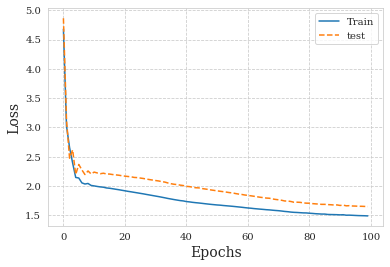

In [31]:
train_loss, test_loss = mlp_fit(final_model, max_iter = 100)

plot_score_loss(train_loss = train_loss,
                test_loss = test_loss,
                save = 0,
                name = 'CUP_sklearn')

In [34]:
mee_final_model = cross_val_score(model, X_CUP_train, y_CUP_train, cv=5, scoring=mee_scoring)
print('VL loss:', np.mean(mee_final_model))

VL loss: -1.5605880737304687


In [36]:
blind_test_results = pd.DataFrame({'Pred x_target': y_pred[:,0], 'Pred y_target': y_pred[:,1]})
blind_test_results.to_csv('Pending-Name_ML-CUP22-TS.csv')
blind_test_results

,Pred x_target,Pred y_target
0,21.565826,-27.017750
1,6.781521,-26.805023
2,12.505049,-30.705002
3,19.494162,-27.844454
4,4.286757,-22.777317
...,...,...
524,16.279787,-29.558578
525,17.152666,-28.869589
526,10.976681,-30.865307
527,4.485310,-19.139492
